**GUYS DISCLAIMER INI AKU NGETEST DOANG YA **

In [11]:
import os
import time
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
file_dir = '/content/drive/MyDrive/BANGKIT/DATASETS/DATASET'
train_dir = os.path.join(file_dir, 'TRAIN')
valid_dir = os.path.join(file_dir, 'TEST')
test_dir = os.path.join(file_dir, 'TEST')

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   fill_mode='reflect',
                                   shear_range=0.3,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=60)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_gen = train_datagen.flow_from_directory(train_dir, 
                                         target_size=(128,128), 
                                         batch_size=128,
                                         class_mode="categorical")

testing_gen = test_datagen.flow_from_directory(test_dir, 
                                               target_size=(128,128), 
                                               batch_size=128,
                                               class_mode="categorical")

validation_gen = val_datagen.flow_from_directory(test_dir, 
                                             target_size=(128,128), 
                                             batch_size=128,
                                             class_mode="categorical")

Found 424 images belonging to 5 classes.
Found 165 images belonging to 5 classes.
Found 165 images belonging to 5 classes.


In [15]:
#file_dir = '/content/drive/MyDrive/BANGKIT/DATASETS/DATASET'

#source_path_leaf = os.path.join(file_dir, 'D')
#source_path_food = os.path.join(file_dir, 'F')
#source_path_branch = os.path.join(file_dir, 'G')
#source_path_vegetable = os.path.join(file_dir, 'O')
#source_path_fruit = os.path.join(file_dir, 'R')

# Deletes all non-image files (there are two .db files bundled into the dataset)
#!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
#print(f"There are {len(os.listdir(source_path_leaf))} images of leaf.")
#print(f"There are {len(os.listdir(source_path_food))} images of food waste.")
#print(f"There are {len(os.listdir(source_path_branch))} images of branch.")
#print(f"There are {len(os.listdir(source_path_vegetable))} images of vegetable.")
#print(f"There are {len(os.listdir(source_path_fruit))} images of fruit.")

In [16]:
print("Train/Validation indicies: ", train_gen.class_indices)
print("\n0 stands for Buah \"B\" \n1 stands for Cangkang Telur \"C\" \n2 stands for Daun \"D\"\n3 stands for Ranting \"R\"\n4 stands for Tulang \"T\"")

Train/Validation indicies:  {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

0 stands for Buah "B" 
1 stands for Cangkang Telur "C" 
2 stands for Daun "D"
3 stands for Ranting "R"
4 stands for Tulang "T"


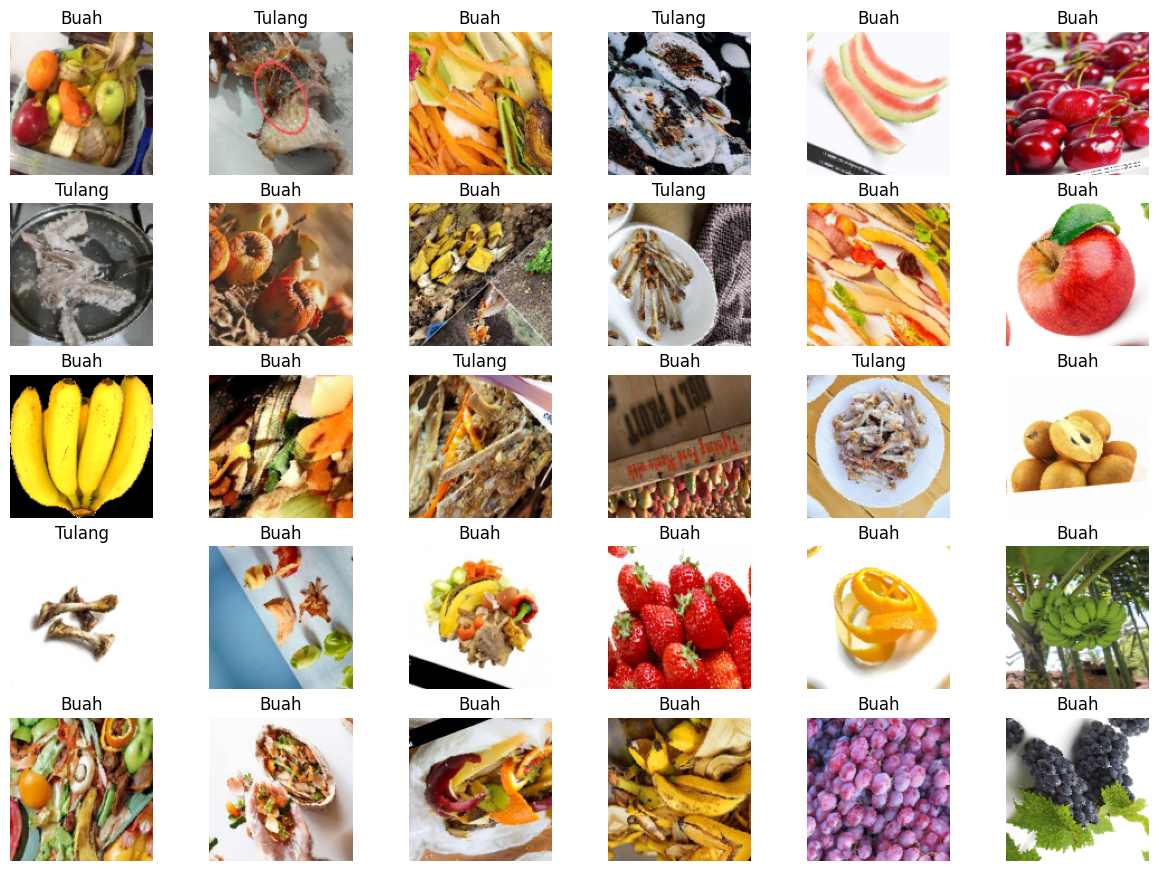

In [24]:
img, labels = next(train_gen)
plt.figure(figsize=(15, 13))
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if labels[i][0] == 1:
        plt.title("Buah")
    elif labels[i][1] == 1:
        plt.title("Cangkang Telur")
    elif labels[i][2] == 1:
        plt.title("Daun")
    elif labels[i][3] == 1:
        plt.title("Ranting")
    else:
        plt.title("Tulang")
    plt.axis("off")
del img
del labels

In [25]:
model = tf.keras.Sequential()

In [26]:
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

In [27]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 128)     

In [28]:
model.compile(optimizer='adam',loss='CategoricalCrossentropy', metrics=['accuracy'])

In [29]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', save_best_only=True)

In [30]:
history = model.fit(train_gen, 
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=30,
                    callbacks=[best_model, early_stopping_monitor]
)

Epoch 1/30
4/4 [==============================] - 78s 24s/step - loss: 1.7206 - accuracy: 0.5259 - val_loss: 2.2688 - val_accuracy: 0.4545
Epoch 2/30
4/4 [==============================] - 19s 4s/step - loss: 1.2769 - accuracy: 0.7689 - val_loss: 1.5465 - val_accuracy: 0.4545
Epoch 3/30
4/4 [==============================] - 17s 5s/step - loss: 1.0107 - accuracy: 0.7689 - val_loss: 1.4354 - val_accuracy: 0.4545
Epoch 4/30
4/4 [==============================] - 18s 4s/step - loss: 0.9061 - accuracy: 0.7689 - val_loss: 1.2689 - val_accuracy: 0.4545
Epoch 5/30
4/4 [==============================] - 17s 5s/step - loss: 0.8313 - accuracy: 0.7689 - val_loss: 1.0997 - val_accuracy: 0.4545
Epoch 6/30
4/4 [==============================] - 17s 5s/step - loss: 0.7710 - accuracy: 0.7689 - val_loss: 1.0527 - val_accuracy: 0.4545
Epoch 7/30
4/4 [==============================] - 18s 4s/step - loss: 0.7144 - accuracy: 0.7689 - val_loss: 1.2901 - val_accuracy: 0.4545
Epoch 8/30
4/4 [=================

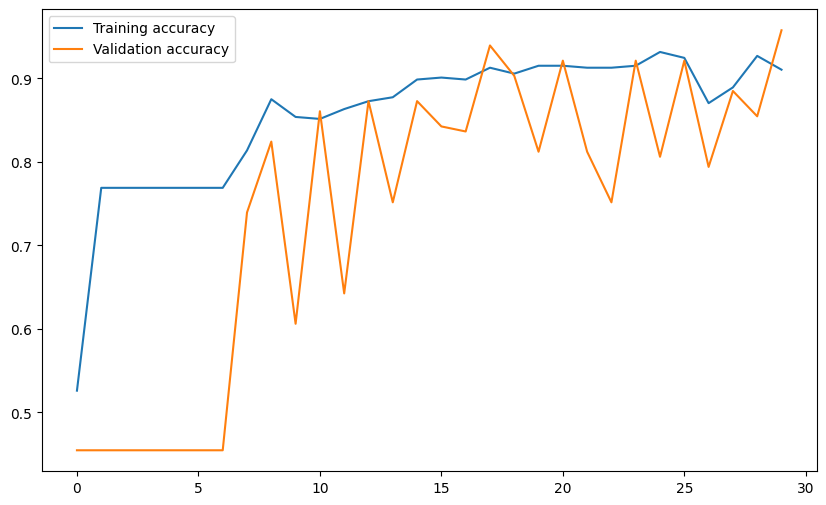

In [31]:
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Training accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation accuracy")
plt.legend()
plt.show()

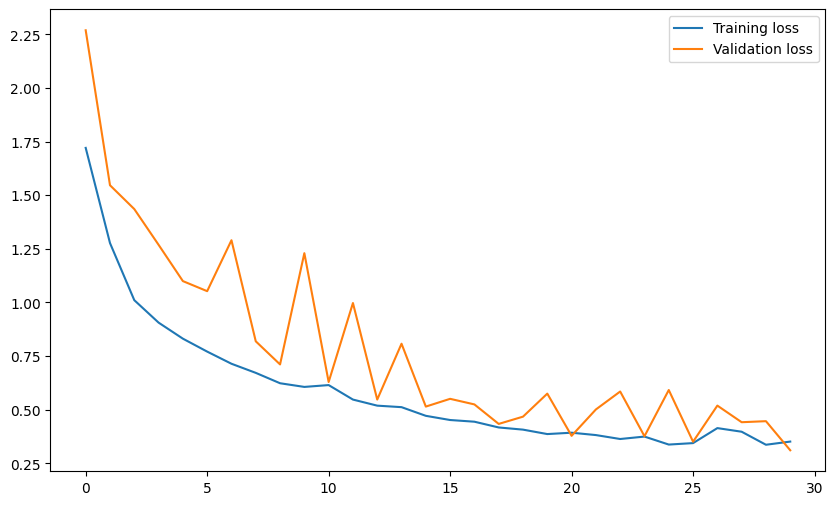

In [32]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [33]:
model.load_weights('bestmodel.hdf5')
model.evaluate(validation_gen);

2/2 [==============================] - 2s 234ms/step - loss: 0.3111 - accuracy: 0.9576


In [34]:
def predict_func(img): 
    result = model.predict(img)
    return result

4/4 [==============================] - 1s 202ms/step


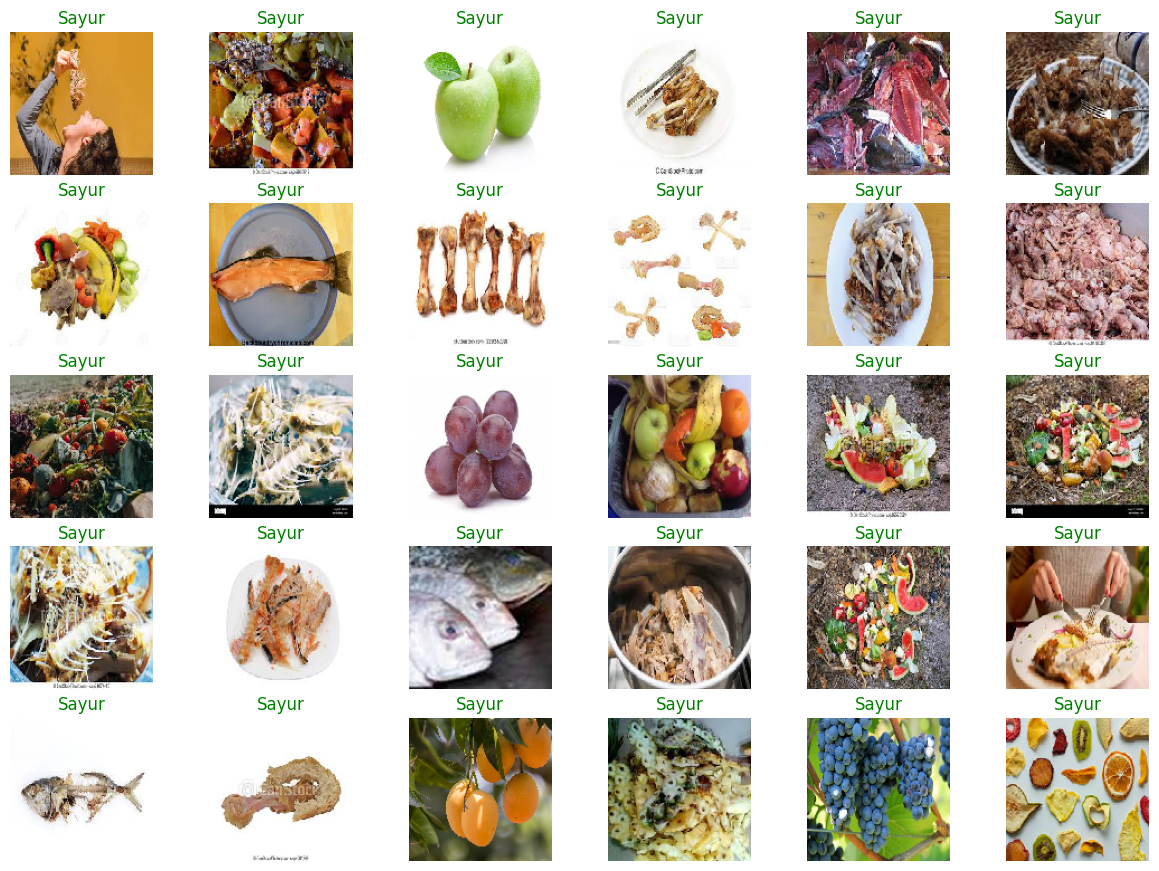

In [35]:
img, _= next(validation_gen)
plt.figure(figsize=(15, 13))
result = model.predict(img)
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if result[i][1] < 0.5:
        pred = 0
        if pred == _[i][1]:
            plt.title("Sayur", color='green')
        else: 
            plt.title("Sayur", color='red')
    else:
        pred = 1
        if pred == _[i][1]:
            plt.title("Buah", color='green')
        else: 
            plt.title("Buah", color='red')
    plt.axis("off")